<h1 align="center">Coffee Shop Location</h1> 
<h5 align="center">by Steven Asten</h5> 



# Contents:
1. <a href="#part_1">Three Capstone Project Ideas</a>
2. <a href="#part_2">New Coffee Shop Location Proposal</a>
3. <a href="#part_3">Exploratory Data Analysis (EDA)</a>
    - <a href="#import_and_structure">Import and structure data sets</a>
    - <a href="#explore_data">Explore data</a>
    - <a href="#explore_data_old">Explore data (Old Hypotheses)</a>
4. <a href="#machine_learning">Machine Learning</a>
    - <a href="#hyp_1">Hypothesis #1</a>
    - <a href="#hyp_2">Hypothesis #2</a>
5. <a href="#conclusion">Conclusion</a>
    

<a id="part_1"></a>

# Part 1 - Three Capstone Project Ideas:

In [1]:
from IPython.display import IFrame
IFrame("./00_ThreeIdeas.pdf", width=800, height=500)

<a id="part_2"></a>

# Part 2: New coffee shop location
#### Problem Statement: What are you trying to solve?
Find a rental property in a location which would be suitable for a new coffee shop. Only DC metro area considered.

#### Data science Hypothesis(es)/solutions considering: One or multiple angles to consider solving this problem with data science  
- Find the location w/ the least amount of competition (other coffee shops), using Yelp dataset
- Find an area with features that may increase foot traffic, such as other nearby shops, public transportation stops, etc.

#### Data sets to be used: Share the links and files, .csvs, .js, .xlsx, .txt, website URLs
- [Yelp Dataset](https://www.yelp.com/dataset)
- [2016 ACS 1-year estimates; Age and Sex](Part2_Proposal/DatasetsForProject/sex_and_age/)
    - This dataset might change or be expanded to include more data; currently the intention is to use it for population data. The data came from [factfinder.census.gov](https://factfinder.census.gov/faces/nav/jsf/pages/download_center.xhtml).

#### Data dictionaries to describe the data types youâ€™re using: write these out in markdown as tables 
- Yelp Dataset - business.json

|Data ID      |Data Type|Data Description                                                           |
|-------------|:-------:|---------------------------------------------------------------------------|
|business_id  |String   |22 character unique string business id                                     |
|name         |String   |the business's name                                                        |
|neighborhood |String   |the neighborhood's name                                                    |
|address      |String   |the full address of the business                                           |
|city         |String   |the city                                                                   |
|state        |String   |2 character state code, if applicable                                      |
|postal code  |String   |the postal code                                                            |
|latitude     |Float    |latitude                                                                   |
|longitude    |Float    |longitude                                                                  |
|stars        |Float    |star rating, rounded to half-stars                                         |
|review_count |Integer  |number of reviews                                                          |
|is_open      |Integer  |0 or 1 for closed or open, respectively                                    |
|attributes   |Object(?)|business attributes to values. note: some attribute values might be objects|
|categories   |Array(?) |an array of strings of business categories                                 |
|hours        |Object(?)|key day to value hours, hours are using a 24hr clock                       |


- 2016 ACS Age and Sex table (might not use this)

|Data ID|Data Type|Data Description|
|-----------------|:-----:|-------------------------------------|
|GEO.id           |String |ID                                   |
|GEO.id2          |String |ID                                   |
|GEO.display-label|String |Display label in format County, State|
|HC01_EST_VC01    |Integer|Estimated total population           |

#### Potential business cases relative to project: how would this help businesses out to make money or save money or improve accuracy or make better products?
This project will allow expanding coffee-shop franchises, as well as entrepreneurs breaking into the coffee shop industry, to find a suitable location for a new coffee shop. By using this analysis, coffee shop owners can avoid opening coffee shops in non-suitable areas, resulting in large savings in capital. Opening a coffee shop in a thriving and expanding area with less competition should also result in higher profits.

#### Potential stakeholders who would find this interesting: who would be your ideal customer or client for this?
Seeing as large franchises like Starbucks already have software which executes this analysis, the ideal customer for this project would be small business owners and prospective entrepreneurs.

#### Potential places to share your results post project (client, world, website, blog)
At this time, I believe the most beneficial method of sharing these results would be through a blog post that would allow the user to reproduce the analysis for different areas (since this will only cover the DC metro area).

<a id="part_3"></a>

# Part 3: Exploratory Data Analysis

<a id="import_and_structure"></a>

# Import data files and save as dataframes.

In [4]:
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

<a id="import_zip"></a>
### Import zip_codes file (which contains all zip codes in dc-metro) into a python list.

In [5]:
import csv
with open('./data/zip_codes.csv', 'r') as f:
    reader = csv.reader(f)
    zip_codes = list(reader)
    
# convert list of lists attained from csv.reader to single flat list
zip_codes_flat = [item for sublist in zip_codes for item in sublist]

<a id="import_acs"></a>
### Import ACS Datasets

In [6]:
# create dataframe with 2015 & 2016 data to compare for change in population
popul2016_df = pd.read_csv('./data/ACS_16_5YR_B01003_with_ann.csv', names=('zip_code', 'estimate_total'), skiprows=1)
popul2016_df = popul2016_df[popul2016_df.zip_code.isin(zip_codes_flat)]
popul2016_df.dtypes

zip_code          int64
estimate_total    int64
dtype: object

In [7]:
popul2016_df['zip_code'] = popul2016_df['zip_code'].astype(str)

In [8]:
zipfeatures_df = pd.read_csv('./data/ACS_15_5YR_B01002_with_ann.csv', names=('zip_code', 'median_age', 'mean_income', 'percent_public_transport'), skiprows=2)
zipfeatures_df['zip_code'] = zipfeatures_df['zip_code'].astype(str)

In [9]:
zipfeatures_df = popul2016_df.merge(zipfeatures_df, on='zip_code')

In [10]:
zipfeatures_df['median_age'] = pd.to_numeric(zipfeatures_df['median_age'], errors='coerce')
zipfeatures_df['mean_income'] = pd.to_numeric(zipfeatures_df['mean_income'], errors='coerce')
zipfeatures_df['percent_public_transport'] = pd.to_numeric(zipfeatures_df['percent_public_transport'], errors='coerce')

In [11]:
zipfeatures_df.dtypes

zip_code                     object
estimate_total                int64
median_age                  float64
mean_income                 float64
percent_public_transport    float64
dtype: object

<a id="yelp_api"></a>
### Import Yelp dataset/call Yelp API.
    - After importing the dataset I found it to be missing all data from DC area (maybe corrupted file?), so I chose to use  Yelp API.
#### Note: <font color=Red>Don't run this code. Outputted, cleaned dataframe saved to file below and re-imported in the next section. I've marked where to begin running in red below.</font>

In [7]:
# businesses = pd.read_json('./data/business.json', lines=True)
# businesses.shape
# businesses.dtypes
# businesses.head()
# businesses[businesses.city.isin(zip_codes_flat)]

In [8]:
# This takes a very long time to run (calls the API 1200ish times; 10 minutes on my PC)
# Query the yelp api for each zip code in the DC metro area
# Since Yelp limit is 50 for businesses returned, we need to loop through pages of 50 using offsets

import requests

url = "https://api.yelp.com/v3/businesses/search"

dict_responses = {}
# for each zip code, gather up to 1001 businesses (should be enough for all businesses in each zip)
for i in zip_codes_flat:
    j = 1
    while j <= 1001:
        querystring = {'location': i, 'limit':50, 'offset':j}

        headers = {
            'authorization': #insert api key,
            'cache-control': "no-cache",
            }

        response = requests.request("GET", url, headers=headers, params=querystring)

        response_todict = response.json()
        try:
            response_todict[str(int(i)+int(j))] = response_todict.pop('businesses')
        except:
            j = 1002
        else:    
            dict_responses.update(response_todict)
            j = j + 50

In [9]:
# Clean up the response from the api

list_of_businesses = []

for key, item in dict_responses.items():
    list_of_businesses.append(item)

del(list_of_businesses[0:2])

# more cleanup; list is currently list of lists of dictionaries due to how api was called
# convert to just list of dictionaries

list_of_businesses_formatting = []

for i in list_of_businesses:
    for j in i:
        list_of_businesses_formatting.append(j)

#### I need to normalize the json data so that each data point is in its own column.

In [10]:
# Change formatting of categories column to only include "title", not "alias" (makes normalization easier)
for idx, val in enumerate(list_of_businesses_formatting):
    list_categories = []
    for idx2, val2 in enumerate(val['categories']):
        list_categories.append(list_of_businesses_formatting[idx]['categories'][idx2]['title'])
    val['categories'] = list_categories

In [11]:
# This isn't technically normalized all the way since categories still has multiple values.
# Good enough for analysis I need
from pandas.io.json import json_normalize
businesses_df = json_normalize(list_of_businesses_formatting)

In [12]:
businesses_df.head(2)

,alias,categories,coordinates.latitude,coordinates.longitude,display_phone,distance,id,image_url,is_closed,location.address1,...,location.display_address,location.state,location.zip_code,name,phone,price,rating,review_count,transactions,url
0,old-ebbitt-grill-washington,"[Bars, American (Traditional), Breakfast & Bru...",38.898005,-77.033362,(202) 347-4800,1428.775801,iyBbcXtQSBfiwFQZwVBNaQ,https://s3-media2.fl.yelpcdn.com/bphoto/KBCezp...,False,675 15th St NW,...,"[675 15th St NW, Washington, DC 20005]",DC,20005,Old Ebbitt Grill,+12023474800,$$,4.0,6544,[],https://www.yelp.com/biz/old-ebbitt-grill-wash...
1,a-baked-joint-washington-9,"[Coffee & Tea, Breakfast & Brunch, Sandwiches]",38.902411,-77.017139,(202) 408-6985,547.273915,SpCeYPhky4gsWa9-IBtw2A,https://s3-media1.fl.yelpcdn.com/bphoto/iTBw1K...,False,440 K St NW,...,"[440 K St NW, Washington, DC 20001]",DC,20001,A Baked Joint,+12024086985,$,4.5,1218,[],https://www.yelp.com/biz/a-baked-joint-washing...


#### My looping api call technique resulted in many duplicates, as we examine and fix below (id is unique).

In [13]:
businesses_df.id.value_counts().head()

SvjE3q-uYpyjqYKh714IPw    16
ynuv5y74SB2gEXFPjMYb_Q    16
F6jgtkBLdyjHYhDO79Z1lA    16
hrWvnULW3ragGALYVEAybA    16
S0WNMOKJ5c3NXuC_-7lE2Q    14
Name: id, dtype: int64

In [14]:
businesses_df.drop_duplicates(subset='id', inplace=True)

In [15]:
businesses_df.shape

(4222, 24)

#### Now I will drop columns that I won't need during this project.

In [16]:
businesses_df.drop(['alias',
         'id',
         'display_phone',
         'distance', 
         'image_url', 
         'is_closed', 
         'location.address2', 
         'location.address3', 
         'location.display_address',
         'phone',
         'transactions',
         'url'], axis=1, inplace=True)

#### Next I'll clean up the column names.

In [17]:
businesses_df.columns = ['categories', 'latitude', 
                         'longitude', 'address', 
                         'city', 'country', 'state', 
                         'zip_code', 'name', 'price', 
                         'rating', 'review_count']

In [18]:
# move name column to first position
cols = businesses_df.columns.tolist()
cols[0] = 'name'
cols[8] = 'categories'
businesses_df = businesses_df[cols]

In [19]:
businesses_df.head()

,name,latitude,longitude,address,city,country,state,zip_code,categories,price,rating,review_count
0,Old Ebbitt Grill,38.898005,-77.033362,675 15th St NW,"Washington, DC",US,DC,20005,"[Bars, American (Traditional), Breakfast & Bru...",$$,4.0,6544
1,A Baked Joint,38.902411,-77.017139,440 K St NW,"Washington, DC",US,DC,20001,"[Coffee & Tea, Breakfast & Brunch, Sandwiches]",$,4.5,1218
2,Le Diplomate,38.911359,-77.031575,1601 14th St NW,"Washington, DC",US,DC,20009,"[Brasseries, French, Cafes]",$$$,4.0,2449
3,Rasika,38.895008,-77.021286,633 D St NW,"Washington, DC",US,DC,20004,[Indian],$$$,4.5,2633
4,Matchbox - Chinatown,38.900050,-77.022540,713 H St NW,"Washington, DC",US,DC,20001,"[Pizza, American (New)]",$$,4.0,2673


#### For whatever reason the API imported some businesses outside of the queried zip codes, so I removed those quick.

In [20]:
businesses_df.shape

(4222, 12)

In [21]:
businesses_df = businesses_df[businesses_df['zip_code'].isin(zip_codes_flat)]

In [22]:
businesses_df.shape

(3175, 12)

#### Check for relevent null values

In [23]:
businesses_df.isnull().sum()

name              0
latitude          1
longitude         1
address          13
city              0
country           0
state             0
zip_code          0
categories        0
price           498
rating            0
review_count      0
dtype: int64

#### Save businesses_df to csv file for quicker use later.

In [24]:
businesses_df.to_csv('./data/businesses.csv', sep='\t')

<a id="import_foursquare"></a>
### Import Foursquare dataset
- These datasets are several gigabytes and were not included in the project repository due to size restrictions of github. You can find the dataset [here](https://sites.google.com/site/yangdingqi/home/foursquare-dataset).

In [59]:
foursquare_checkins_df = pd.read_csv("../../../dataset_TIST2015/dataset_TIST2015_Checkins.txt", header=None, delimiter="\t")

foursquare_checkins_df.drop([3], axis=1, inplace=True)
foursquare_checkins_df.columns = ['user_id', 'venue_id', 'utc_time']

In [60]:
foursquare_poi_df = pd.read_csv("../../../dataset_TIST2015/dataset_TIST2015_POIs.txt", header=None, delimiter="\t")

foursquare_poi_df.columns = ['venue_id', 'latitude', 'longitude', 'venue_category', 'country']
foursquare_poi_df = foursquare_poi_df[foursquare_poi_df['country'].isin(['US'])]

In [61]:
foursquare_merge_df = foursquare_checkins_df.merge(foursquare_poi_df, on="venue_id")

In [62]:
foursquare_merge_df.head()

,user_id,venue_id,utc_time,latitude,longitude,venue_category,country
0,221021,4a85b1b3f964a520eefe1fe3,Tue Apr 03 18:00:08 +0000 2012,40.748939,-73.99228,Coffee Shop,US
1,89453,4a85b1b3f964a520eefe1fe3,Tue Apr 24 22:53:57 +0000 2012,40.748939,-73.99228,Coffee Shop,US
2,206753,4a85b1b3f964a520eefe1fe3,Thu May 03 16:20:48 +0000 2012,40.748939,-73.99228,Coffee Shop,US
3,114526,4a85b1b3f964a520eefe1fe3,Wed May 09 23:09:45 +0000 2012,40.748939,-73.99228,Coffee Shop,US
4,86634,4a85b1b3f964a520eefe1fe3,Tue May 22 13:31:13 +0000 2012,40.748939,-73.99228,Coffee Shop,US


In [63]:
foursquare_merge_df.shape

(3564144, 7)

#### Now I want to pull out the the users who visited a coffee shop at least once. I'll create a new column called "coffee_shop_bin". If the user visited a coffee shop on the selected day, all rows for that day will be set to 1. Else, 0. Later I'll use this in my models to predict where people are coming from when they go to a coffee shop.
- I'll overwrite the same DF to cut down on memory usage...

In [64]:
# reduce the dataframe to include only users who have visited a coffee shop
coffee_drinkers = foursquare_merge_df[foursquare_merge_df.venue_category.isin(['Coffee Shop'])].user_id.unique().tolist()
foursquare_merge_df = foursquare_merge_df[foursquare_merge_df.user_id.isin(coffee_drinkers)]

In [65]:
foursquare_merge_df.shape

(2439117, 7)

In [66]:
# convert utc_time to datetime object, takes 5-10 minutes
foursquare_merge_df['utc_time'] = pd.to_datetime(foursquare_merge_df['utc_time'], infer_datetime_format=True)
foursquare_merge_df.dtypes

user_id                    int64
venue_id                  object
utc_time          datetime64[ns]
latitude                 float64
longitude                float64
venue_category            object
country                   object
dtype: object

In [67]:
# this is super inefficient, but shouldn't need to be run again. took approx. 20 minutes.
# groups df by user id, month, day, then checks each group for coffee shop visits
grouped_foursquare = foursquare_merge_df.groupby([foursquare_merge_df.user_id, 
                                                   foursquare_merge_df.utc_time.dt.month, 
                                                   foursquare_merge_df.utc_time.dt.day])
# if group contains a coffee shop check-in, set all values of coffee_shop_bin in that group to yes
grouped_foursquare_true = grouped_foursquare.filter(lambda x: x['venue_category'].str.contains('Coffee').any())
grouped_foursquare_true['coffee_shop_bin'] = 1
# if group does not contain a coffee shop check-in, set all values of coffee_shop_bin in that group to yes
grouped_foursquare_false = grouped_foursquare.filter(lambda x: ~x['venue_category'].str.contains('Coffee').any())
grouped_foursquare_false['coffee_shop_bin'] = 0

# re-combine the true and false datasets
grouped_foursquare = grouped_foursquare_true.append(grouped_foursquare_false, ignore_index=True)

C:\Users\Steven\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Steven\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [68]:
# make sure we didn't lose any data
print("Full data: " + str(foursquare_merge_df.shape))
print("Checkins from days w/ coffee shop visits: " + str(grouped_foursquare_true.shape))
print("Checkins from days w/out coffee shop visits: " + str(grouped_foursquare_false.shape))
print("Data after concat: " + str(grouped_foursquare.shape))

Full data: (2439117, 7)
Checkins from days w/ coffee shop visits: (309677, 8)
Checkins from days w/out coffee shop visits: (2129440, 8)
Data after concat: (2439117, 8)


#### Get address data from longitude and latitude.
- I tried using geopy to get the city from the coordinates, which appears to work, but it would take 20 straight days to run all 3.5 million lines. Will explore this later. Most geolocaters also have a query limit which this would far exceed.

In [18]:
from geopy.geocoders import Nominatim
import time

start_time = time.time()

i=0
for index, row in foursquare_merge_df.iterrows():
    if i < 10:
        coord = str(row['latitude']) + "," + str(row['longitude'])

        geolocator = Nominatim()
        location = geolocator.reverse(coord)
        if "District of Columbia" in location.address: 
            print(location.address)
        i+=1
    else:
        break
        
print("10 lines: --- %s seconds ---" % (time.time() - start_time))

# geolocator = Nominatim()
# location = geolocator.reverse("38.898005, -77.033362")
# print(location.address)


10 lines: --- 10.996055603027344 seconds ---


- Trying a package I found on github called reverse_geocoder to cut down on query time. This only took a few minutes to run, but unfortunately only returned high level geography (Washington, D.C).

In [69]:
import reverse_geocoder as rg

coordinates = []
for index, row in grouped_foursquare.iterrows():
    coordinates.append((row.latitude, row.longitude))
    
results = rg.search(coordinates)

In [70]:
dc_bools = []

for i in results:
    result = "D.C" in str(i)
    dc_bools.append(result)

In [71]:
dc_bools[0:5]

[False, False, False, False, False]

In [72]:
grouped_foursquare['check_in_dc'] = dc_bools

In [73]:
grouped_foursquare.check_in_dc.value_counts()

False    2372042
True       67075
Name: check_in_dc, dtype: int64

In [74]:
grouped_foursquare = grouped_foursquare[grouped_foursquare.check_in_dc == True]
grouped_foursquare.drop('check_in_dc', axis=1, inplace=True)

#### I want to continue reverse geocoding to get zip codes. I'll pull in Zillow neighborhood shapefiles.

In [75]:
import geopandas as gpd
shape = gpd.read_file('data/ZillowNeighborhoods-DC.shp')

In [76]:
shape.head()

,State,County,City,Name,RegionID,geometry
0,DC,District of Columbia,Washington,Barnaby Woods,121672,POLYGON ((-77.04528160099994 38.97573291100008...
1,DC,District of Columbia,Washington,Bellevue,121674,POLYGON ((-77.01639139799994 38.80931882600004...
2,DC,District of Columbia,Washington,Benning,121675,POLYGON ((-76.95024865099992 38.88970558200003...
3,DC,District of Columbia,Washington,Chevy Chase,121689,POLYGON ((-77.05323999999973 38.97290000000029...
4,DC,District of Columbia,Washington,Dupont Park,121705,POLYGON ((-76.94706749892596 38.88285577097802...


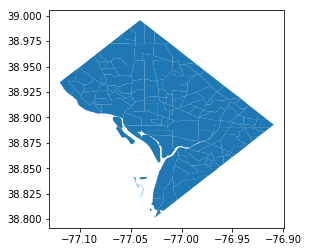

In [77]:
shape.plot()

In [78]:
# https://stackoverflow.com/questions/7861196/check-if-a-geopoint-with-latitude-and-longitude-is-within-a-shapefile?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
# credit to Richard

import ogr
from IPython import embed
import sys

drv = ogr.GetDriverByName('ESRI Shapefile') #We will load a shape file
ds_in = drv.Open("data/ZillowNeighborhoods-DC.shp")    #Get the contents of the shape file
lyr_in = ds_in.GetLayer(0)    #Get the shape file's first layer

#Put the title of the field you are interested in here
idx_reg = lyr_in.GetLayerDefn().GetFieldIndex("name")

#If the latitude/longitude we're going to use is not in the projection
#of the shapefile, then we will get erroneous results.
#The following assumes that the latitude longitude is in WGS84
#This is identified by the number "4326", as in "EPSG:4326"
#We will create a transformation between this and the shapefile's
#project, whatever it may be
geo_ref = lyr_in.GetSpatialRef()
point_ref=ogr.osr.SpatialReference()
point_ref.ImportFromEPSG(4326)
ctran=ogr.osr.CoordinateTransformation(point_ref,geo_ref)

def check(lon,lat):
    #Create a point
    pt = ogr.Geometry(ogr.wkbPoint)
    pt.SetPoint_2D(0, lon, lat)

    #Set up a spatial filter such that the only features we see when we
    #loop through "lyr_in" are those which overlap the point defined above
    lyr_in.SetSpatialFilter(pt)

    #Loop through the overlapped features and display the field of interest
    for feat_in in lyr_in:
        return feat_in.GetFieldAsString(idx_reg)

In [79]:
this_is_a_neighborhoods = []
for index, row in grouped_foursquare.iterrows():
    this_is_a_neighborhoods.append(check(row.longitude, row.latitude))

In [80]:
this_is_a_neighborhoods[0:10]

['Dupont Circle',
 'Shaw',
 'Shaw',
 'Shaw',
 'Shaw',
 'Shaw',
 'Capitol Hill',
 'Downtown',
 'Navy Yard',
 'Navy Yard']

In [81]:
import csv
with open('./data/neighborhoodsToZip.csv', 'r') as f:
    reader = csv.reader(f)
    conversion = dict(reader)
del conversion['Neighborhood']

In [82]:
conversion

{'': '20001',
 'Adams Morgan': '20009',
 'American University Park': '20016',
 'Arboretum': '20002',
 'Barnaby Woods': '20015',
 'Barry Farm': '20020',
 'Bellevue': '20032',
 'Benning': '20019',
 'Benning Heights': '20019',
 'Bloomingdale': '20017',
 'Brentwood': '20722',
 'Brightwood': '20011',
 'Brightwood Park': '20011',
 'Brookland': '20017',
 'Buena Vista': '20020',
 'Burleith': '20007',
 'Burrville': '20019',
 'Buzzard Point': '20024',
 'Capitol Hill': '20003',
 'Capitol View': '20020',
 'Cardozo': '20001',
 'Carver Langston': '20002',
 'Cathedral Heights': '20016',
 'Chevy Chase': '20015',
 'Chinatown': '20001',
 'Cleveland Park': '20008',
 'Colonial Village': '20012',
 'Columbia Heights': '20010',
 'Congress Heights': '20032',
 'Connecticut Avenue': '20036',
 'Crestwood': '20011',
 'Deanwood': '20019',
 'Douglass': '20020',
 'Downtown': '20001',
 'Dupont Circle': '20036',
 'Dupont Park': '20020',
 'Eastland Gardens': '20019',
 'Eckington': '20002',
 'Edgewood': '20017',
 'Fairf

In [83]:
conversions = []
for i in this_is_a_neighborhoods:
    try:
        conversions.append(conversion[i])
    except KeyError:
        conversions.append('99999')

In [84]:
print(len(conversions))
print(grouped_foursquare.shape)

67075
(67075, 8)


In [85]:
grouped_foursquare['zip_code'] = conversions

In [86]:
grouped_foursquare.zip_code.value_counts()

20001    19509
99999    16804
20036     6731
20003     4237
20007     3827
20004     3296
20002     3058
20037     2834
20009     2131
20010     2120
20008     1144
20024      876
20017      485
20722       18
20020        3
20011        2
Name: zip_code, dtype: int64

In [87]:
# some neighborhoods did not convert to zip code correctly. Due to time restrictions and 
# previous issues with geocoding, I'm simply going to drop them for now.
grouped_foursquare = grouped_foursquare[grouped_foursquare.zip_code != '99999']

In [88]:
grouped_foursquare.zip_code.value_counts()

20001    19509
20036     6731
20003     4237
20007     3827
20004     3296
20002     3058
20037     2834
20009     2131
20010     2120
20008     1144
20024      876
20017      485
20722       18
20020        3
20011        2
Name: zip_code, dtype: int64

In [92]:
grouped_foursquare.venue_category.value_counts().head()

Coffee Shop            2378
Office                 2223
Subway                 2043
American Restaurant    1844
Bar                    1804
Name: venue_category, dtype: int64

#### Export the altered dataframe into a file for later use

In [25]:
grouped_foursquare.to_csv('./data/foursquare.csv', sep='\t')

<a id="reimport_data"></a>
## Import cleaned datasets
#### <font color=Red>Start running here to import cleaned dataframes; reading dataframes into memory and re-converting datatypes</font>

In [12]:
businesses_df = pd.read_csv('./data/businesses.csv', sep="\t", index_col=0, encoding='latin-1')
businesses_df.dtypes

name             object
latitude        float64
longitude       float64
address          object
city             object
country          object
state            object
zip_code          int64
categories       object
price            object
rating          float64
review_count      int64
dtype: object

In [13]:
businesses_df['zip_code'] = businesses_df['zip_code'].astype(str)

In [14]:
businesses_df.head()

,name,latitude,longitude,address,city,country,state,zip_code,categories,price,rating,review_count
0,Old Ebbitt Grill,38.898005,-77.033362,675 15th St NW,"Washington, DC",US,DC,20005,"['Bars', 'American (Traditional)', 'Breakfast ...",$$,4.0,6544
1,A Baked Joint,38.902411,-77.017139,440 K St NW,"Washington, DC",US,DC,20001,"['Coffee & Tea', 'Breakfast & Brunch', 'Sandwi...",$,4.5,1218
2,Le Diplomate,38.911359,-77.031575,1601 14th St NW,"Washington, DC",US,DC,20009,"['Brasseries', 'French', 'Cafes']",$$$,4.0,2449
3,Rasika,38.895008,-77.021286,633 D St NW,"Washington, DC",US,DC,20004,['Indian'],$$$,4.5,2633
4,Matchbox - Chinatown,38.900050,-77.022540,713 H St NW,"Washington, DC",US,DC,20001,"['Pizza', 'American (New)']",$$,4.0,2673


In [15]:
foursquare_df = pd.read_csv('./data/foursquare.csv', sep="\t", index_col=0)
foursquare_df['utc_time'] = pd.to_datetime(foursquare_df['utc_time'], infer_datetime_format=True)
foursquare_df['zip_code'] = foursquare_df['zip_code'].astype(str)
foursquare_df.dtypes
# foursquare_df.shape

user_id                     int64
venue_id                   object
utc_time           datetime64[ns]
latitude                  float64
longitude                 float64
venue_category             object
country                    object
coffee_shop_bin             int64
zip_code                   object
dtype: object

<a id="explore_data"></a>

## Explore Data

### Hypothesis 1: Find where people who go to coffee shops go on the same day, and then find a location with a lot of this type of establishment.

- First, I'll need to pick which categories I'll include, and then transcribe them to individual columns. Each row will be one day for one user, and the values for each category column will be 1 if the person visited this type of category on that day, and 0 if not.

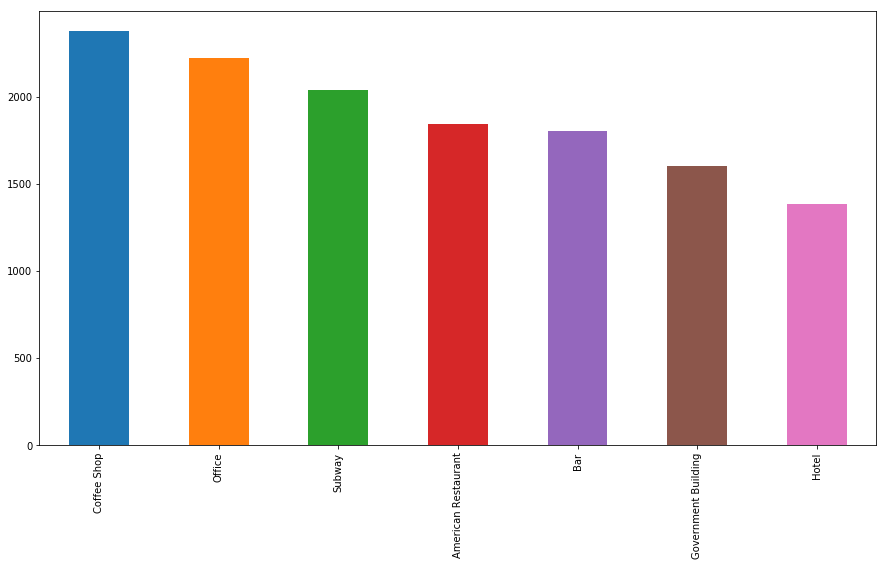

In [16]:
foursquare_df.venue_category.value_counts().head(7).plot(kind='bar', figsize=(15, 8))

In [17]:
# first, list all of the columns
foursquare_df.venue_category.unique()

array(['Shoe Store', 'Lounge', 'Bar', 'Sandwich Place',
       'Baseball Stadium', 'Zoo', 'Greek Restaurant', 'Bank',
       'Train Station', 'Neighborhood', 'American Restaurant',
       'Coffee Shop', 'Tech Startup', 'Seafood Restaurant', 'Subway',
       'Pizza Place', 'History Museum', 'Mall', 'Hotel',
       'Government Building', 'Department Store', 'Gym / Fitness Center',
       'Indian Restaurant', 'Light Rail', 'Sports Bar', 'Caf\x1a\x1a',
       'Cocktail Bar', 'Yoga Studio', 'Clothing Store', 'Military Base',
       'Bookstore', 'Gym', 'Park', 'Plaza', 'Whisky Bar', 'Office',
       'Community College', 'Museum', 'Mediterranean Restaurant', 'Pub',
       'Breakfast Spot', 'High School', 'Nightlife Spot', 'Grocery Store',
       'Steakhouse', "Men's Store", 'Music Venue', 'Hotel Bar', 'Theater',
       'Dive Bar', 'Italian Restaurant', 'Fast Food Restaurant',
       'Liquor Store', 'Turkish Restaurant', 'Ice Cream Shop',
       'Drugstore / Pharmacy', 'Cafeteria', 'Arts & Cra

In [18]:
# for now, I'll just use the top 23 categories as my features
columns=foursquare_df.venue_category.value_counts().head(23).index.values
columns

array(['Coffee Shop', 'Office', 'Subway', 'American Restaurant', 'Bar',
       'Government Building', 'Hotel', 'Train Station', 'Gym',
       'Grocery Store', 'Home (private)',
       'Residential Building (Apartment / Condo)', 'Park',
       'Mexican Restaurant', 'Sandwich Place', 'Lounge', 'Building',
       'Pizza Place', 'Pub', 'Neighborhood', 'Baseball Stadium', 'Road',
       'Italian Restaurant'], dtype=object)

In [19]:
foursquare_days_df = foursquare_df.rename(columns={'utc_time':'utc_time_full'}).groupby([foursquare_df.user_id, foursquare_df.utc_time.dt.day]).nth(0).reset_index(drop=True)
foursquare_days_df.drop(['venue_id', 'latitude', 'longitude', 'venue_category', 'country', 'coffee_shop_bin', 'zip_code'], axis=1, inplace=True)
foursquare_days_df.head()

,user_id,utc_time_full
0,6,2013-04-03 16:49:50
1,6,2012-10-18 16:01:06
2,6,2013-05-22 20:16:02
3,6,2013-02-27 18:10:19
4,6,2012-11-28 15:04:14


In [20]:
foursquare_df_temp = foursquare_df[foursquare_df.venue_category.isin(columns)]

In [21]:
foursquare_days_df = pd.read_csv('./data/foursquare_days_df.csv')

In [606]:
# DON'T RUN THIS! :)
# takes 15+ minutes. Running the cell block directly above this will import the same dataset
# as this code block produces.

# transposes check in data w/ user/date as primary key and 1/0 for whether 
# or not the user visited said category
for column in columns:
    foursquare_days_df[column] = foursquare_days_df.apply(lambda row: 1 if foursquare_df_temp[(foursquare_df_temp['user_id'] == row['user_id']) & (foursquare_df_temp.utc_time.dt.day == row['utc_time_full'].day) & (foursquare_df_temp.venue_category == column)].venue_category.count() > 0 else 0, axis=1)
    foursquare_df_temp = foursquare_df_temp[foursquare_df_temp['venue_category'] != column]

964.9314014144293

In [22]:
foursquare_days_df.head()

,Unnamed: 0,user_id,utc_time_full,Coffee Shop,Office,Subway,American Restaurant,Bar,Government Building,Hotel,...,Mexican Restaurant,Sandwich Place,Lounge,Building,Pizza Place,Pub,Neighborhood,Baseball Stadium,Road,Italian Restaurant
0,0,6,2013-04-03 16:49:50,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,6,2012-10-18 16:01:06,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,6,2013-05-22 20:16:02,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,6,2013-02-27 18:10:19,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4,6,2012-11-28 15:04:14,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
foursquare_days_df['Coffee Shop'].value_counts()

0    15507
1     1930
Name: Coffee Shop, dtype: int64

In [24]:
foursquare_days_df.shape 

(17437, 26)

#### foursquare_days_df is now formatted and ready for a decision tree (Machine Learning section)

### Hypothesis 2: compare various factors of each zip code to the check in count to find a linear relationship. If we can find a linear relationship, we can use this to determine the best zip code for maximizing coffee shop check-ins.

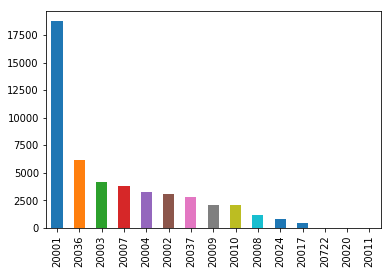

In [25]:
foursquare_df.zip_code.value_counts().plot(kind='bar')

In [26]:
coffee_checkins_perzip = foursquare_df[foursquare_df.venue_category == "Coffee Shop"].groupby(['zip_code']).size().reset_index(name='coffeeshop_counts')

In [27]:
checkins_and_zipdata_df = coffee_checkins_perzip.merge(zipfeatures_df, left_on='zip_code', right_on='zip_code')

In [28]:
checkins_and_zipdata_df.corr().coffeeshop_counts

coffeeshop_counts           1.000000
estimate_total              0.244147
median_age                 -0.362762
mean_income                -0.108608
percent_public_transport   -0.244719
Name: coffeeshop_counts, dtype: float64

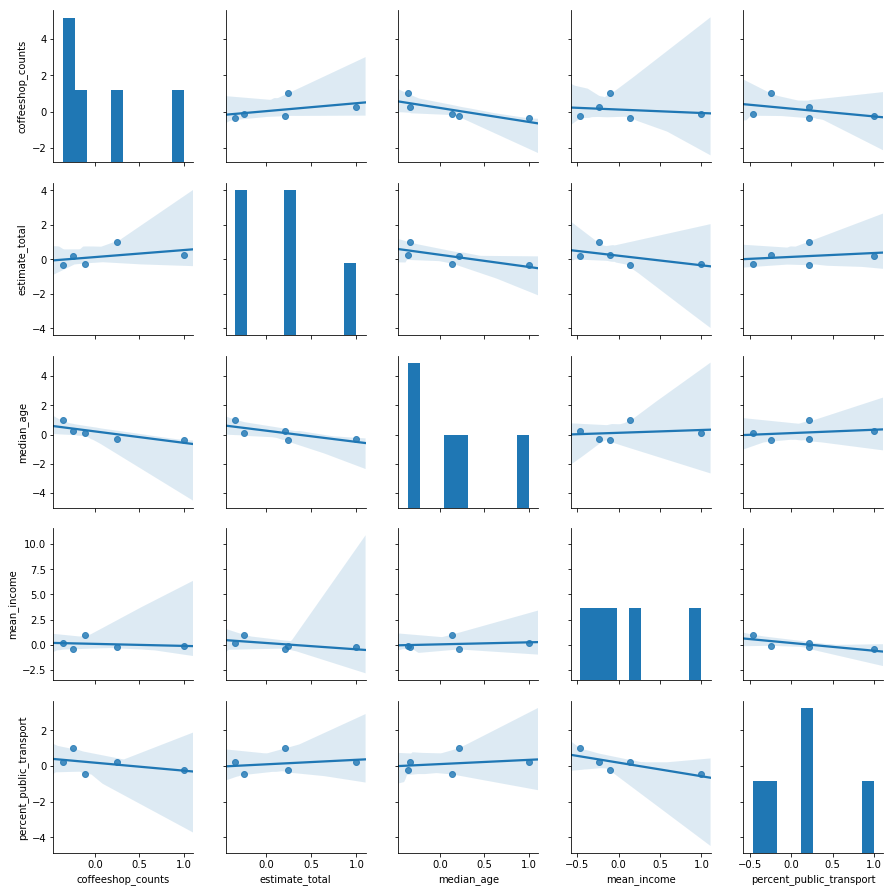

In [29]:
import seaborn as sns
sns.pairplot(checkins_and_zipdata_df.corr(), kind='reg')
# sns.regplot(x="estimate_total", y="coffeeshop_counts", data=checkins_and_zipdata_df);
# sns.regplot(x="mean_income", y="coffeeshop_counts", data=checkins_and_zipdata_df);
# sns.regplot(x="median_age", y="coffeeshop_counts", data=checkins_and_zipdata_df);

<a id="explore_data_old"></a>

## Explore Data (Old Hypotheses)

#### See where people are generally coming from when they go to coffee shops

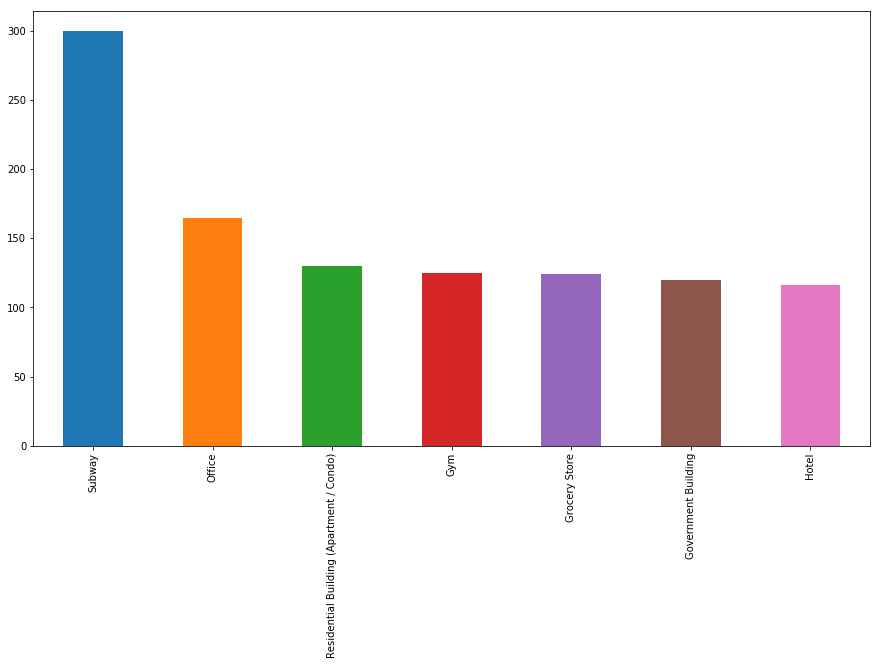

In [29]:
# View top 10 categories of checkins on days that also contain a coffee shop checkin
foursquare_df[(foursquare_df.coffee_shop_bin==1) & (foursquare_df.venue_category != 'Coffee Shop')].venue_category.value_counts().head(7).plot(kind='bar', figsize=(15, 8))

#### Next I'd like to view coffee shops plotted on an interactive map.

In [31]:
import folium

map_coffee_df = businesses_df[businesses_df.categories.astype(str).str.contains('Coffee')]

folium_map = folium.Map(location=[38.9031434, -77.0232301],
                        zoom_start=13)

for index, row in map_coffee_df.iterrows():
    folium.Marker([row["latitude"], row["longitude"]], popup=folium.Popup(row['name'], parse_html=True)).add_to(folium_map)

In [32]:
folium_map

#### Next I want to find a count of coffee shops by zip code and explore population data viability on determining coffee shop location

In [33]:
# get all businesses w/ category containing "Coffee"
coffeeshops_byzip_df = businesses_df[businesses_df.categories.astype(str).str.contains('Coffee')]
coffeeshops_byzip_df.shape

(390, 12)

In [33]:
# new df containing each zip code and the count of coffee shops
coffeeshop_percap_df = coffeeshops_byzip_df.groupby('zip_code').zip_code.agg(['count']).sort_values('count', ascending=False)

# merge previous dataframe with population growth dataframe
coffeeshop_percap_df = coffeeshop_percap_df.merge(popul2016_df, left_index=True, right_on="zip_code")
coffeeshop_percap_df = coffeeshop_percap_df.set_index('zip_code')

# add calculated field for rate of population change
coffeeshop_percap_df['pop_change_rate'] = (coffeeshop_percap_df['estimate_total_2016'] - \
                                            coffeeshop_percap_df['estimate_total_2015']) / \
                                            coffeeshop_percap_df['estimate_total_2015']

# display some rows from newly constructed df, sorted by population rate of change
coffeeshop_percap_df[coffeeshop_percap_df['count'] > 5].sort_values('pop_change_rate')

<a id="machine_learning"></a>

## Part 4: Machine Learning

<a id="hyp_1"></a>

### Hypothesis 1: Find where people who go to coffee shops go on the same day, and then find a location with a lot of this type of establishment.

#### First get baseline accuracy for classification models

In [59]:
foursquare_days_df['baseline'] = 0

In [61]:
print('Baseline Accuracy: ', str(accuracy_score(foursquare_days_df['Coffee Shop'], foursquare_days_df['baseline'])))

Baseline Accuracy:  0.889315822675919


#### Model 1: Decision Tree

In [34]:
feature_cols = ['Office', 'Subway', 'American Restaurant', 'Bar',
       'Government Building', 'Hotel', 'Train Station', 'Gym',
       'Grocery Store', 'Home (private)',
       'Residential Building (Apartment / Condo)', 'Park',
       'Mexican Restaurant', 'Sandwich Place', 'Lounge', 'Building',
       'Pizza Place', 'Pub', 'Neighborhood', 'Baseball Stadium', 'Road',
       'Italian Restaurant']

X = foursquare_days_df[feature_cols]
y = foursquare_days_df["Coffee Shop"]

In [35]:
from sklearn.tree import DecisionTreeClassifier

treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X, y)

pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_}).sort_values('importance', ascending=False).head(10)

,feature,importance
11,Park,0.290257
1,Subway,0.238393
13,Sandwich Place,0.233781
7,Gym,0.190744
6,Train Station,0.046825
20,Road,0.000000
19,Baseball Stadium,0.000000
18,Neighborhood,0.000000
17,Pub,0.000000
16,Pizza Place,0.000000


In [36]:
foursquare_days_df[foursquare_days_df['Subway'] == 1]['Coffee Shop'].value_counts()

0    1030
1     207
Name: Coffee Shop, dtype: int64

In [39]:
from sklearn.tree import export_graphviz
import pydotplus
from io import StringIO

import os     
os.environ["PATH"] += os.pathsep + 'C:\\Users\\Steven\\Anaconda3\\Library\\bin\\graphviz'

dotfile = StringIO()
export_graphviz(treeclf, out_file=dotfile, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dotfile.getvalue())
graph.write_png('./assets/categories_tree.png')

True

![Tree for category data](assets/categories_tree.png)|

In [40]:
feature_cols = ['Office', 'Subway', 'American Restaurant', 'Bar',
       'Government Building', 'Hotel', 'Train Station', 'Gym',
       'Grocery Store', 'Home (private)',
       'Residential Building (Apartment / Condo)', 'Park',
       'Mexican Restaurant', 'Sandwich Place', 'Lounge', 'Building',
       'Pizza Place', 'Pub', 'Neighborhood', 'Baseball Stadium', 'Road',
       'Italian Restaurant']

X = foursquare_days_df[feature_cols]
y = foursquare_days_df["Coffee Shop"]

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
treeclf = DecisionTreeClassifier(max_depth=3)
treeclf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [42]:
from sklearn.metrics import accuracy_score

y_predict = treeclf.predict(X_test)
print('Accuracy: ', str(accuracy_score(y_test, y_predict)))

Accuracy:  0.8832568807339449


#### Model 2: Random Forest Classifier

In [43]:
feature_cols = ['Office', 'Subway', 'American Restaurant', 'Bar',
       'Government Building', 'Hotel', 'Train Station', 'Gym',
       'Grocery Store', 'Home (private)',
       'Residential Building (Apartment / Condo)', 'Park',
       'Mexican Restaurant', 'Sandwich Place', 'Lounge', 'Building',
       'Pizza Place', 'Pub', 'Neighborhood', 'Baseball Stadium', 'Road',
       'Italian Restaurant']

X = foursquare_days_df[feature_cols]
y = foursquare_days_df["Coffee Shop"]

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

rfclas = RandomForestClassifier(n_estimators=150, max_features=5, oob_score=True)
rfclas.fit(X, y)

pd.DataFrame({'feature':feature_cols, 'importance':rfclas.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
1,Subway,0.071853
0,Office,0.066635
2,American Restaurant,0.061696
9,Home (private),0.058930
8,Grocery Store,0.055555
4,Government Building,0.053220
11,Park,0.052196
6,Train Station,0.051449
10,Residential Building (Apartment / Condo),0.049291
12,Mexican Restaurant,0.048944


In [45]:
rfclas = RandomForestClassifier(n_estimators=150, max_features=5, oob_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y)
rfclas.fit(X_train, y_train)
y_predict = rfclas.predict(X_test)
print('accuracy: ' + str(accuracy_score(y_test, y_predict)))

pd.DataFrame({'feature':feature_cols, 'importance':rfclas.feature_importances_}).sort_values('importance', ascending=False).head()

accuracy: 0.8869266055045871


,feature,importance
0,Office,0.074169
2,American Restaurant,0.065981
1,Subway,0.065383
9,Home (private),0.056564
4,Government Building,0.056298


#### Hypothesis 1 conclusion
- The first model I used was a decision tree, and then I tried implementing a random forest. What I found was that the decision tree was much easier to interpret due to its ability to pick out the most important features, rather than using all of the features. The accuracy was also almost exactly the same. From this I found that the most common places for a person to visit on the same day as a coffee shop are the park, Subway, a Sandwich Place (other than subway I presume), the Gym, and a Train Station.

<a id="hyp_2"></a>

### Hypothesis 2: compare various factors of each zip code to the check in count to find a linear relationship. If we can find a linear relationship, we can use this to determine the best zip code for maximizing coffee shop check-ins.

In [21]:
checkins_and_zipdata_df

,zip_code,coffeeshop_counts,estimate_total,median_age,mean_income,percent_public_transport
0,20001,942,44998,30.6,106670.0,0.353349
1,20002,172,59659,34.0,98792.0,0.361972
2,20003,225,29071,34.8,140336.0,0.401540
3,20004,148,1708,41.0,173373.0,0.312452
4,20007,175,26415,33.2,180698.0,0.233151
5,20008,14,28261,37.1,164615.0,0.477948
6,20009,97,51508,32.3,121153.0,0.433303
7,20010,101,32421,32.0,92937.0,0.504061
8,20017,41,20371,37.5,81027.0,0.388251
9,20024,1,12183,38.2,90712.0,0.441809


In [119]:
# get mean squared error of baseline
import numpy as np

actual = checkins_and_zipdata_df.coffeeshop_counts.tolist()
checkins_and_zipdata_df['predicted'] = checkins_and_zipdata_df.coffeeshop_counts.mean()
predicted = checkins_and_zipdata_df.predicted.tolist()
print('Baseline RMSE: ', np.sqrt(metrics.mean_squared_error(actual, predicted)))

Baseline RMSE:  243.66125165


In [120]:
checkins_and_zipdata_df.corr().coffeeshop_counts

coffeeshop_counts           1.000000
estimate_total              0.244147
median_age                 -0.362762
mean_income                -0.108608
percent_public_transport   -0.244719
predicted                        NaN
Name: coffeeshop_counts, dtype: float64

In [121]:
from sklearn.linear_model import LinearRegression
feature_cols = ['median_age', 'percent_public_transport']

X = checkins_and_zipdata_df[feature_cols]
y = checkins_and_zipdata_df.coffeeshop_counts

lr = LinearRegression()
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [122]:
list(zip(feature_cols, lr.coef_))

[('median_age', -21.503951021339549),
 ('percent_public_transport', -562.59521272186237)]

In [123]:
# compare predicted value of one record to the actual value.
print(lr.predict([[34, .361972]]))
print(checkins_and_zipdata_df[checkins_and_zipdata_df.zip_code == '20002'].coffeeshop_counts.values)

[ 211.91765413]
[172]


In [190]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

feature_cols = ['median_age', 'percent_public_transport']

X = checkins_and_zipdata_df[feature_cols]
y = checkins_and_zipdata_df.coffeeshop_counts

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print('RMSE: ', str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

RMSE:  117.931658217


#### Hypothesis 2 conclusion
- Based on the coefficients and correlations found from the above linear regression model, of the listed features age and public_transport percentage are the most significant factors in coffee shop checkins. The other features do not increase model accuracy. For every additional year on the median age, coffee shop check-ins goes down by 20. Therefor, I should look for the zip code with the lowest median age.
- The model is more accurate than the baseline, but it is still very inaccurate due to the very small size of the dataset.

## Machine Learning Conclusion
- Based on the results of the models executed in this section, I am looking for the zip code with the greatest presense of parks and sandwich shops, with the lowest median age.

<a id="conclusion"></a>

## Conclusion
- Build new dataframe with zip codes and their relevant characteristics for analysis.

In [23]:
find_best_zip = businesses_df[businesses_df.categories.str.contains('Sandwich')].groupby('zip_code').agg('count').name.reset_index(name="sandwich")
find_best_zip = find_best_zip.merge(businesses_df[businesses_df.categories.str.contains('Park')].groupby('zip_code').agg('count').name.reset_index(name="park"))

# since the model revealed that these two categories are weighted similarly,
# I'll just add them.
find_best_zip = find_best_zip.merge(businesses_df[businesses_df.categories.str.contains('Coffee')].groupby('zip_code').agg('count').name.reset_index(name="coffee"))

In [28]:
find_best_zip.sort_values('sandwich', ascending=False).head(10)

,zip_code,sandwich,park,coffee
0,20001,54,8,43
4,20005,36,2,33
5,20006,34,5,31
8,20009,30,4,41
1,20002,28,5,33
3,20004,23,1,20
2,20003,22,9,20
18,20036,21,1,27
16,20024,21,7,15
6,20007,18,6,20


In [29]:
# add the median age
find_best_zip = find_best_zip.merge(zipfeatures_df[['zip_code', 'median_age', 'percent_public_transport']])

In [30]:
find_best_zip.sort_values('sandwich', ascending=False).head(10)

,zip_code,sandwich,park,coffee,median_age,percent_public_transport
0,20001,54,8,43,30.6,0.353349
4,20005,36,2,33,33.8,0.264241
5,20006,34,5,31,20.6,0.287554
8,20009,30,4,41,32.3,0.433303
1,20002,28,5,33,34.0,0.361972
3,20004,23,1,20,41.0,0.312452
2,20003,22,9,20,34.8,0.401540
18,20036,21,1,27,32.7,0.363870
16,20024,21,7,15,38.2,0.441809
6,20007,18,6,20,33.2,0.233151


It is tempting to go with the 20001 zip code, but we can see that there are already 43 coffee shops in this area, and the median age is significantly higher than the next row down. 20006 has a significant number of parks and sandwich shops, and a relatively low number of coffee shops. It also has the lowest median age on the list. For these reasons, I have selected the 20006 zip code.

In [31]:
businesses_20006zip_df = businesses_df[(businesses_df.categories.str.contains('Coffee')) & 
              (businesses_df.zip_code.isin(['20006', '20036']))]

At this point I ran into an issue that I did not anticipate. There were no suitable properties available in 20006, as far as I could find. That being said, just a few blocks north is 20036. The data above for 20036 is not as ideal, but the median age is still relatively low, and it's close enough to 20006. The percentage of people who use public transportation is also significantly higher. I found several properties in this location, and chose the one denoted with a red mark below.

In [32]:
import folium

folium_map = folium.Map(location=[38.904265, -77.041656],
                        zoom_start=15)

for index, row in businesses_20006zip_df.iterrows():
    folium.Marker([row["latitude"], row["longitude"]], popup=folium.Popup(row['name'], parse_html=True)).add_to(folium_map)
    
folium.Marker([38.9062766, -77.0418966], icon=folium.Icon(color="red"), popup=folium.Popup('Selected Location', parse_html=True)).add_to(folium_map)

folium_map

In [33]:
# here is a flier for the property from the property management company.
from IPython.display import IFrame
IFrame("./assets/document.pdf", width=800, height=600)